## Airbnb DC Hosting Helper ##

## 5_modeling ##

### Summary ###

In this notebook, I will be exploring different modeling tecniques to see what the best fit is for my data. 

Import libraries and read in data

In [437]:
#! pip install -U imbalanced-learn

In [438]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [22]:
np.random.seed(100)

In [23]:
pd.set_option('display.max_columns', 300)

In [24]:
pd.set_option('display.max_rows', 300)

In [184]:
df = pd.read_csv('../data/final_df.csv')

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 100 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Unnamed: 0                                3652 non-null   int64  
 1   id                                        3652 non-null   int64  
 2   name                                      3652 non-null   object 
 3   description                               3609 non-null   object 
 4   neighborhood_overview                     2794 non-null   object 
 5   host_id                                   3652 non-null   int64  
 6   host_about                                2529 non-null   object 
 7   host_response_time                        3652 non-null   object 
 8   host_response_rate                        3652 non-null   float64
 9   host_acceptance_rate                      3652 non-null   float64
 10  host_is_superhost                  

Drop unnecessary columns for modeling.

In [186]:
df.drop(columns = ['Unnamed: 0', 'id', 'host_id',  'amenities', 'latitude_x', 'longitude_x',
                   'name', 'description', 'neighborhood_overview', 'host_about'
                  ], inplace=True)

Get dummies for categorical columns

In [187]:
df = pd.get_dummies(df,columns = ['host_response_time', 'neighbourhood_cleansed', 'room_type'], drop_first=True)

In [188]:
df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,instant_bookable,calculated_host_listings_count,historic site,museum,metro,music venue,perfomring arts venue,college and university,food,nightlife spot,outdoors and recreation,government building,clothing store,popular,days_being_host,days_since_first_review,days_since_last_review,name_word_count,name_neutral_sentiment,name_negative_sentiment,name_positive_sentiment,name_compound_sentiment,description_word_count,description_neutral_sentiment,description_negative_sentiment,description_positive_sentiment,description_compound_sentiment,neighborhood_overview_word_count,neighborhood_overview_neutral_sentiment,neighborhood_overview_negative_sentiment,neighborhood_overview_positive_sentiment,neighborhood_overview_compound_sentiment,host_about_word_count,host_about_neutral_sentiment,host_about_negative_sentiment,host_about_positive_sentiment,host_about_compound_sentiment,wifi,smoke alarm,essentials,heating,air conditioning,hangers,iron,kitchen,long term stays allowed,hair dryer,carbon monoxide alarm,hot water,shampoo,dedicated workspace,dishes and silverware,microwave,washer,dryer,fire extinguisher,refrigerator,coffee maker,cooking basics,private entrance,bed linens,stove,oven,free street parking,dishwasher,first aid kit,extra pillows and blankets,tv,patio or balcony,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,"neighbourhood_cleansed_Brookland, Brentwood, Langdon","neighbourhood_cleansed_Capitol Hill, Lincoln Park","neighbourhood_cleansed_Capitol View, Marshall Heights, Benning Heights","neighbourhood_cleansed_Cathedral Heights, McLean Gardens, Glover Park","neighbourhood_cleansed_Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace","neighbourhood_cleansed_Colonial Village, Shepherd Park, North Portal Estates","neighbourhood_cleansed_Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View","neighbourhood_cleansed_Congress Heights, Bellevue, Washington Highlands","neighbourhood_cleansed_Deanwood, Burrville, Grant Park, Lincoln Heights, Fairmont Heights","neighbourhood_cleansed_Douglas, Shipley Terrace","neighbourhood_cleansed_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street","neighbourhood_cleansed_Dupont Circle, Connecticut Avenue/K Street","neighbourhood_cleansed_Eastland Gardens, Kenilworth","neighbourhood_cleansed_Edgewood, Bloomingdale, Truxton Circle, Eckington","neighbourhood_cleansed_Fairfax Village, Naylor Gardens, Hillcrest, Summit Park","neighbourhood_cleansed_Friendship Heights, American University Park, Tenleytown","neighbourhood_cleansed_Georgetown, Burleith/Hillandale","neighbourhood_cleansed_Hawthorne, Barnaby Woods, Chevy Chase",neighbourhood_cleansed_Historic Anacostia,"neighbourhood_cleansed_Howard University, Le Droit Park, Cardozo/Shaw","neighbourhood_cleansed_Ivy City, Arboretum, Trinidad, Carver Langston","neighbourhood_cleansed_Kalorama Heights, Adams Morgan, Lanier Heights","neighbourhood_cleansed_Lamont Riggs, Queens Chapel, Fort Totten, Pleasant Hill","neighbourhood_cleansed_Mayfair, Hillbrook, Mahaning Heights","neighbourhood_cleansed_Near Southeast, Navy Yard","neighbourhood_cleansed_North Cleveland Park, Forest Hills, Van Ness","neighbourhood_cleansed_North Michigan Park, Michigan Park, University Heights","neighbourhood_cleansed_River Terrace, Benning, Greenway, Dupont Park","neighbourhood_cleansed_Shaw, Logan Circle","neighbourhood_cleansed_Sheridan, Barry Farm, Buena Vista","neighbourhood_cleansed_Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point","neighbourhood_cleansed_Spring Valley, Palisades, Wesley Heights, Foxhall Crescent, Foxhall Villa

In [189]:
df.shape

(3652, 132)

Below, I will with testing out a kitchen sink model including all variables as a first step. I want to see which models are performing best for the specific metrics I am looking to optimize. I think it's important that the model I select has as consistent scores as possible between training and testing groups and that the accuracy scores for both groups are high to explain as much variance as possible. I will also focus on models that optimize the precision score (true positives over all predicted positives), because in this specific case it would be worse to tell a host that their listing will be popular if it is actually not.

In [190]:
df['popular'].value_counts(normalize=True)

0    0.776835
1    0.223165
Name: popular, dtype: float64

Above is our baseline score that we are hoping to improve upon with our models. Right now, this is saying that our baseline score is 78%, so we would be correct in guessing 78% of the time with the current informaiton. 

Set testing and training groups for modeling. Scale variables. 

In [191]:
X = df.drop(columns=['popular'])

y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y )

In [192]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

Run training and testing data through a quick pipe function to see which models perform the best on my data.

In [124]:
def pipe(model):
    #instantiate model
    model = model()
    #fit to scaled data
    model.fit(X_train_sc, y_train)
    
    #make predictions
    predictions = model.predict(X_test_sc)

    #print results
    print(f'{model} training accuracy score: {model.score(X_train_sc, y_train)}')
    print(f'{model} testing accuracy score: {model.score(X_test_sc, y_test)}')

    print(f'{model} testing f1 score: {f1_score(y_test, predictions)}')
    print(f'{model} testing precision score: {precision_score(y_test, predictions)}')
    print(f'{model} testing recall score: {recall_score(y_test, predictions)}')

    return

In [61]:
pipe(KNeighborsClassifier)

KNeighborsClassifier() training accuracy score: 0.8375319459656809
KNeighborsClassifier() testing accuracy score: 0.7502738225629791
KNeighborsClassifier() testing f1 score: 0.4356435643564357
KNeighborsClassifier() testing precision score: 0.44
KNeighborsClassifier() testing recall score: 0.43137254901960786


In [60]:
pipe(BernoulliNB)

BernoulliNB() training accuracy score: 0.7579408543263965
BernoulliNB() testing accuracy score: 0.7579408543263965
BernoulliNB() testing f1 score: 0.5623762376237623
BernoulliNB() testing precision score: 0.4717607973421927
BernoulliNB() testing recall score: 0.696078431372549


In [55]:
pipe(DecisionTreeClassifier)

DecisionTreeClassifier() training accuracy score: 1.0
DecisionTreeClassifier() testing accuracy score: 0.8116100766703176
DecisionTreeClassifier() testing f1 score: 0.5678391959798995
DecisionTreeClassifier() testing precision score: 0.5824742268041238
DecisionTreeClassifier() testing recall score: 0.553921568627451


In [57]:
pipe(AdaBoostClassifier)

AdaBoostClassifier() training accuracy score: 0.8722161372763783
AdaBoostClassifier() testing accuracy score: 0.8378970427163198
AdaBoostClassifier() testing f1 score: 0.6262626262626263
AdaBoostClassifier() testing precision score: 0.6458333333333334
AdaBoostClassifier() testing recall score: 0.6078431372549019


In [54]:
pipe(LogisticRegression)

LogisticRegression() training accuracy score: 0.8587075575027382
LogisticRegression() testing accuracy score: 0.828039430449069
LogisticRegression() testing f1 score: 0.5698630136986301
LogisticRegression() testing precision score: 0.6459627329192547
LogisticRegression() testing recall score: 0.5098039215686274


In [64]:
pipe(BaggingClassifier)

BaggingClassifier() training accuracy score: 0.9883169039795546
BaggingClassifier() testing accuracy score: 0.8389923329682366
BaggingClassifier() testing f1 score: 0.608
BaggingClassifier() testing precision score: 0.6666666666666666
BaggingClassifier() testing recall score: 0.5588235294117647


In [56]:
pipe(GradientBoostingClassifier)

GradientBoostingClassifier() training accuracy score: 0.913837166849215
GradientBoostingClassifier() testing accuracy score: 0.8510405257393209
GradientBoostingClassifier() testing f1 score: 0.6548223350253807
GradientBoostingClassifier() testing precision score: 0.6789473684210526
GradientBoostingClassifier() testing recall score: 0.6323529411764706


In [59]:
pipe(SVC)

SVC() training accuracy score: 0.900693683826214
SVC() testing accuracy score: 0.8400876232201533
SVC() testing f1 score: 0.546583850931677
SVC() testing precision score: 0.7457627118644068
SVC() testing recall score: 0.43137254901960786


In [58]:
pipe(RandomForestClassifier)

RandomForestClassifier() training accuracy score: 1.0
RandomForestClassifier() testing accuracy score: 0.8455640744797371
RandomForestClassifier() testing f1 score: 0.5523809523809523
RandomForestClassifier() testing precision score: 0.7837837837837838
RandomForestClassifier() testing recall score: 0.4264705882352941


In [63]:
pipe(ExtraTreesClassifier)

ExtraTreesClassifier() training accuracy score: 1.0
ExtraTreesClassifier() testing accuracy score: 0.8422782037239869
ExtraTreesClassifier() testing f1 score: 0.5263157894736842
ExtraTreesClassifier() testing precision score: 0.8
ExtraTreesClassifier() testing recall score: 0.39215686274509803


Above, I organized the models from least to greatest perforance on accuracy and precision scores for testing data. The random forest and extra tree classifiers had the highest accuraccy and precision scores so I will use these models for further tuning and testing. It is nice to see that the models are performing better than the baseline scores so I know we are headed in the right direction.

My goal is to have a best predictive model that best optimizes for my specific metrics, and have an interpretable model that can help interpret the characteristics of a listing that hosts could improve on to increase their likelihood of having a popular listing. Below, I will be using logistic regression to start interpreting and understanding how the features in my data affect the popularity target variable. 

In [193]:
logreg = LogisticRegression()

logreg.fit(X_train_sc, y_train)

predictions = logreg.predict(X_test_sc)

print(f'training accuracy score: {logreg.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {logreg.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 0.859802847754655
testing accuracy score: 0.8214676889375685
testing f1 score: 0.5630026809651475
testing precision score: 0.621301775147929
testing recall score: 0.5147058823529411


In [66]:
sorted(set(zip(logreg.coef_[0], X.columns)), reverse=True)

[(1.1102103727962551, 'days_since_first_review'),
 (0.8339420621488186, 'host_is_superhost'),
 (0.3807734628498279, 'accommodates'),
 (0.3761790105371492, 'description_neutral_sentiment'),
 (0.36106647017172744, 'dishes and silverware'),
 (0.295677498656564, 'host_response_time_unknown'),
 (0.2583796968849898, 'host_about_positive_sentiment'),
 (0.24011745750887833, 'hair dryer'),
 (0.2344109232286528, 'host_acceptance_rate'),
 (0.20187327517265977, 'iron'),
 (0.19026759240960972, 'first aid kit'),
 (0.17963116234785026, 'minimum_nights'),
 (0.1785015539472061, 'bed linens'),
 (0.16268916957704646, 'host_about_word_count'),
 (0.15981737786805045,
  'neighbourhood_cleansed_Woodridge, Fort Lincoln, Gateway'),
 (0.1580980910637868, 'host_has_profile_pic'),
 (0.13067911788955958, 'availability_90'),
 (0.12156521124043425, 'hangers'),
 (0.11389455780914667, 'neighborhood_overview_negative_sentiment'),
 (0.11372852961850613, 'hot water'),
 (0.1114702544860492, 'neighborhood_overview_compound

An expample of how to interpret the first coefficient - as days since first review increases by 1, the log-odds of someone being a popular listing increases by 1.11.

In [136]:
sorted(set(zip(np.exp(logreg.coef_[0]), X.columns ) ), reverse=True)


[(3.174067102149455, 'days_since_first_review'),
 (2.481712646914296, 'host_is_superhost'),
 (1.768251551577092, 'accommodates'),
 (1.5491101582639857, 'dishes and silverware'),
 (1.5146273544697761, 'minimum_nights'),
 (1.4280869499711912, 'description_neutral_sentiment'),
 (1.3111375528468163, 'host_response_time_unknown'),
 (1.2750809629578579, 'host_acceptance_rate'),
 (1.2584870893816744, 'hair dryer'),
 (1.2562549552764126, 'availability_90'),
 (1.2388868039716374, 'description_compound_sentiment'),
 (1.2079879271203953, 'iron'),
 (1.207242470732563, 'hot water'),
 (1.2037002797426262, 'smoke alarm'),
 (1.194673747278297, 'neighborhood_overview_positive_sentiment'),
 (1.1851867303800223, 'host_about_positive_sentiment'),
 (1.183427987272677, 'name_positive_sentiment'),
 (1.1817060753783268, 'bed linens'),
 (1.1588705965973354, 'hangers'),
 (1.1548019505334912, 'host_has_profile_pic'),
 (1.134866211653753, 'free street parking'),
 (1.1347711530764553, 'neighbourhood_cleansed_West 

An expample of how to interpret the first coefficient after they have been untransformed from their logged version - as days since first review increases by 1, the listing is 3.02 times more likely to be popular. Keep in mind that for a variable that was dummified such as neighborhood, this is in relation to the category that was dropped first for interpretation.

Just a note for interpretation that our terms will be an increase of 1 scaled unit since we used standard scaler on our dataset. Standard scaler is necessary when features in a dataset are on very different scales. It brings the mean of the features to 0 and their standard deviation to 1. This is just a point of clarification for interpreting results.

Below I will begin working on my best predictive model. I will mainly expiriment with random forest and extra tree classifiers since they performed the best above. 

First, I will try keeping the 30 most important features and neighborhoods to see how it performs. 

In [194]:
coef_list = sorted(set(zip(np.exp(logreg.coef_[0]), X.columns ) ), reverse=True)

In [454]:
for i,j in coef_list[0:31]:
    print("'"+j+"',")

'days_since_first_review',
'host_is_superhost',
'dishes and silverware',
'accommodates',
'description_neutral_sentiment',
'neighborhood_overview_positive_sentiment',
'hair dryer',
'host_acceptance_rate',
'host_about_positive_sentiment',
'carbon monoxide alarm',
'name_positive_sentiment',
'hangers',
'host_about_word_count',
'description_compound_sentiment',
'neighbourhood_cleansed_Woodridge, Fort Lincoln, Gateway',
'neighbourhood_cleansed_West End, Foggy Bottom, GWU',
'first aid kit',
'iron',
'minimum_nights',
'neighbourhood_cleansed_Sheridan, Barry Farm, Buena Vista',
'washer',
'host_has_profile_pic',
'availability_90',
'host_response_time_unknown',
'neighborhood_overview_negative_sentiment',
'dishwasher',
'neighbourhood_cleansed_River Terrace, Benning, Greenway, Dupont Park',
'name_word_count',
'college and university',
'description_negative_sentiment',
'neighbourhood_cleansed_Friendship Heights, American University Park, Tenleytown',


In [340]:
X = df[['days_since_first_review',
'host_is_superhost',
'dishes and silverware',
'accommodates',
'description_neutral_sentiment',
'neighborhood_overview_positive_sentiment',
'hair dryer',
'host_acceptance_rate',
'host_about_positive_sentiment',
'carbon monoxide alarm',
'name_positive_sentiment',
'hangers',
'host_about_word_count',
'description_compound_sentiment',
'neighbourhood_cleansed_Woodridge, Fort Lincoln, Gateway',
'neighbourhood_cleansed_West End, Foggy Bottom, GWU',
'first aid kit',
'iron',
'minimum_nights',
'neighbourhood_cleansed_Sheridan, Barry Farm, Buena Vista',
'washer',
'host_has_profile_pic',
'availability_90',
'host_response_time_unknown',
'neighborhood_overview_negative_sentiment',
'dishwasher',
'neighbourhood_cleansed_River Terrace, Benning, Greenway, Dupont Park',
'name_word_count',
'college and university',
'description_negative_sentiment',
'neighbourhood_cleansed_Friendship Heights, American University Park, Tenleytown',
       ]]

y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y )

In [341]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

In [342]:
et = ExtraTreesClassifier()

et.fit(X_train_sc, y_train)

predictions = et.predict(X_test_sc)

print(f'training accuracy score: {et.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {et.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.8466593647316539
testing f1 score: 0.6067415730337078
testing precision score: 0.7105263157894737
testing recall score: 0.5294117647058824


In [343]:
rf = RandomForestClassifier()

rf.fit(X_train_sc, y_train)

predictions = rf.predict(X_test_sc)

print(f'training accuracy score: {rf.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {rf.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.8554216867469879
testing f1 score: 0.6184971098265896
testing precision score: 0.7535211267605634
testing recall score: 0.5245098039215687


Try top 10 features with Extra Trees. 

In [334]:
X = df[['days_since_first_review',
'host_is_superhost',
'dishes and silverware',
'accommodates',
'description_neutral_sentiment',
'neighborhood_overview_positive_sentiment',
'hair dryer',
'host_acceptance_rate',
'host_about_positive_sentiment',
'carbon monoxide alarm'
        
       ]]

y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y )

In [335]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

In [338]:
et = ExtraTreesClassifier()

et.fit(X_train_sc, y_train)

predictions = et.predict(X_test_sc)

print(f'training accuracy score: {et.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {et.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.8510405257393209
testing f1 score: 0.6222222222222223
testing precision score: 0.717948717948718
testing recall score: 0.5490196078431373


Try top 50 features with Extra Trees and Random Forest below. 

In [318]:
X = df[['days_since_first_review',
'host_is_superhost',
'dishes and silverware',
'accommodates',
'description_neutral_sentiment',
'neighborhood_overview_positive_sentiment',
'hair dryer',
'host_acceptance_rate',
'host_about_positive_sentiment',
'carbon monoxide alarm',
'name_positive_sentiment',
'hangers',
'host_about_word_count',
'description_compound_sentiment',
'neighbourhood_cleansed_Woodridge, Fort Lincoln, Gateway',
'neighbourhood_cleansed_West End, Foggy Bottom, GWU',
'first aid kit',
'iron',
'minimum_nights',
'neighbourhood_cleansed_Sheridan, Barry Farm, Buena Vista',
'washer',
'host_has_profile_pic',
'availability_90',
'host_response_time_unknown',
'neighborhood_overview_negative_sentiment',
'dishwasher',
'neighbourhood_cleansed_River Terrace, Benning, Greenway, Dupont Park',
'name_word_count',
'college and university',
'description_negative_sentiment',
'neighbourhood_cleansed_Friendship Heights, American University Park, Tenleytown',
'shampoo',
'instant_bookable',
'free street parking',
'food',
'clothing store',
'host_identity_verified',
'neighbourhood_cleansed_Brookland, Brentwood, Langdon',
'neighbourhood_cleansed_North Cleveland Park, Forest Hills, Van Ness',
'smoke alarm',
'neighbourhood_cleansed_Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace',
'refrigerator',
'neighbourhood_cleansed_Takoma, Brightwood, Manor Park',
'neighbourhood_cleansed_Capitol Hill, Lincoln Park',
'wifi',
'perfomring arts venue',
'dedicated workspace',
'patio or balcony',
'government building',
'extra pillows and blankets',
'host_about_neutral_sentiment'
        
       ]]

y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y )

In [319]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

In [320]:
et = ExtraTreesClassifier()

et.fit(X_train_sc, y_train)

predictions = et.predict(X_test_sc)

print(f'training accuracy score: {et.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {et.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.8411829134720701
testing f1 score: 0.5697329376854599
testing precision score: 0.7218045112781954
testing recall score: 0.47058823529411764


In [321]:
rf = RandomForestClassifier()

rf.fit(X_train_sc, y_train)

predictions = rf.predict(X_test_sc)

print(f'training accuracy score: {rf.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {rf.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.8488499452354874
testing f1 score: 0.6057142857142858
testing precision score: 0.726027397260274
testing recall score: 0.5196078431372549


Try top variables that I think are most important.

In [344]:
X = df[['days_since_first_review',  'host_is_superhost',  'accommodates', 'host_acceptance_rate','host_has_profile_pic',
        'host_response_time_unknown',
        
        'dishes and silverware', 'hair dryer', 'iron', 'first aid kit', 'bed linens', 'hangers','refrigerator', 
        'carbon monoxide alarm', 'smoke alarm', 'free street parking', 'dedicated workspace','shampoo', 'food', 'oven',
        'dishwasher', 'coffee maker', 
        
        'host_about_word_count', 'neighborhood_overview_word_count', 'description_word_count', 'name_word_count',
        'neighborhood_overview_compound_sentiment', 'host_about_compound_sentiment', 'description_compound_sentiment','name_compound_sentiment',
        
        'neighbourhood_cleansed_Woodridge, Fort Lincoln, Gateway', 
        'neighbourhood_cleansed_North Cleveland Park, Forest Hills, Van Ness',
        'neighbourhood_cleansed_West End, Foggy Bottom, GWU',
        'neighbourhood_cleansed_Brookland, Brentwood, Langdon',
        'neighbourhood_cleansed_Eastland Gardens, Kenilworth'
        
       ]]

y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y )

In [345]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

In [346]:
et = ExtraTreesClassifier()

et.fit(X_train_sc, y_train)

predictions = et.predict(X_test_sc)

print(f'training accuracy score: {et.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {et.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.8324205914567361
testing f1 score: 0.5590778097982708
testing precision score: 0.6783216783216783
testing recall score: 0.47549019607843135


In [347]:
rf = RandomForestClassifier()

rf.fit(X_train_sc, y_train)

predictions = rf.predict(X_test_sc)

print(f'training accuracy score: {rf.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {rf.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.8346111719605696
testing f1 score: 0.5770308123249299
testing precision score: 0.673202614379085
testing recall score: 0.5049019607843137


Try mix of most important variables and logical variables. 

In [348]:
X = df[['days_since_first_review',  'host_is_superhost',  'accommodates', 'host_acceptance_rate','host_has_profile_pic',
        'minimum_nights','availability_90',
        
        'dishes and silverware', 'hair dryer', 'iron', 'first aid kit', 'bed linens', 'hangers','refrigerator', 
        'carbon monoxide alarm', 'smoke alarm', 'free street parking', 'dedicated workspace','shampoo', 'oven',
        'dishwasher', 'coffee maker', 'washer','extra pillows and blankets',
        
        'host_about_word_count', 'name_word_count',
        'description_compound_sentiment',
        'description_neutral_sentiment',
        'neighborhood_overview_positive_sentiment',
        'host_about_positive_sentiment',
        'name_positive_sentiment',
        'host_about_neutral_sentiment',
        
        'neighbourhood_cleansed_Woodridge, Fort Lincoln, Gateway', 
        'neighbourhood_cleansed_North Cleveland Park, Forest Hills, Van Ness',
        'neighbourhood_cleansed_West End, Foggy Bottom, GWU',
        'neighbourhood_cleansed_Brookland, Brentwood, Langdon',
        'neighbourhood_cleansed_Eastland Gardens, Kenilworth',
        'neighbourhood_cleansed_Sheridan, Barry Farm, Buena Vista'
        
       ]]

y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y )

In [349]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

In [350]:
et = ExtraTreesClassifier()

et.fit(X_train_sc, y_train)

predictions = et.predict(X_test_sc)

print(f'training accuracy score: {et.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {et.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.8269441401971522
testing f1 score: 0.5485714285714285
testing precision score: 0.6575342465753424
testing recall score: 0.47058823529411764


The results from all of the test cases above are interesting. I organized a list of features based on their logistic regression coefficient values from greatest to smallest. I then tried including the top 10, 30, and 50 features in random forest and extra trees models to see if a change in the number of features included could improve the model. I also did a few models where I took these features into account, but also hand selected features from EDA that I thought may make a difference (such as amenities that were more common for the popular listings). However, I was not able to improve any upon the kitchen sink model, and the precision scores were even lower that the baseline score in all cases. 

After thinking through why these attempts did not actually get me a better result than the kitchen sink model that I started with, it may be that the kitchen sink model with extra tress is the best model for my data. The majority of these features are dummy variables (whether or not a listing has an amenity or is in a certain neighborhood). The Extra Trees Classifier does very well with sorting through this type of informaiton and deciding what is noise and what effects the prediction. It could be that all of these binary features together were needed for the extra trees model to be more informative so the model features did not need to be paired down. 

Below, I will attempt other sampling methods using the extra trees classifier with all features included in the model. 

Try oversampling minority class (popular).

In [397]:
X = df.drop(columns=['popular'])
y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y )

In [398]:
X_sample = pd.concat([X_train, y_train], axis=1)

popular = X_sample[X_sample['popular']==1]

not_popular = X_sample[X_sample['popular']==0]

In [399]:
popular_sample = resample(popular, replace=True, n_samples=len(not_popular))

In [400]:
updated_sample = pd.concat([not_popular, popular_sample])

In [402]:
updated_sample['popular'].value_counts()

0    2128
1    2128
Name: popular, dtype: int64

In [403]:
X_train = updated_sample.drop(columns=['popular'])

y_train = updated_sample['popular']

In [404]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

In [410]:
et = ExtraTreesClassifier()

et.fit(X_train_sc, y_train)

predictions = et.predict(X_test_sc)

print(f'training accuracy score: {et.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {et.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.8422782037239869
testing f1 score: 0.52
testing precision score: 0.8125
testing recall score: 0.38235294117647056


Try undersampling majority class. 

In [413]:
X = df.drop(columns=['popular'])
y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y )

In [414]:
X_sample = pd.concat([X_train, y_train], axis=1)

popular = X_sample[X_sample['popular']==1]

not_popular = X_sample[X_sample['popular']==0]

In [415]:
not_popular_sample = resample(not_popular, replace=True, n_samples=len(popular))

In [416]:
updated_sample = pd.concat([popular, not_popular_sample])

In [417]:
updated_sample['popular'].value_counts()

0    611
1    611
Name: popular, dtype: int64

In [418]:
X_train = updated_sample.drop(columns=['popular'])

y_train = updated_sample['popular']

In [419]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

In [420]:
et = ExtraTreesClassifier()

et.fit(X_train_sc, y_train)

predictions = et.predict(X_test_sc)

print(f'training accuracy score: {et.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {et.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.764512595837897
testing f1 score: 0.6153846153846155
testing precision score: 0.48450704225352115
testing recall score: 0.8431372549019608


Try synthetic samples of minority class. 

In [450]:
X = df.drop(columns=['popular'])
y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y )

In [451]:
sm = SMOTE(sampling_strategy=1.0)

X_train, y_train = sm.fit_resample(X_train, y_train)

In [452]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

In [453]:
et = ExtraTreesClassifier()

et.fit(X_train_sc, y_train)

predictions = et.predict(X_test_sc)

print(f'training accuracy score: {et.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {et.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.8499452354874042
testing f1 score: 0.6478149100257069
testing precision score: 0.6810810810810811
testing recall score: 0.6176470588235294


It turns out that oversampling the minority class of popular yielded the best results for optimizing precision and accuracy. Below I will try grid searching to hypertune the extra trees model.

In [459]:
X = df.drop(columns=['popular'])
y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y )

In [460]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('et' , ExtraTreesClassifier())
])

In [461]:
pipe.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()), ('et', ExtraTreesClassifier())],
 'verbose': False,
 'ss': StandardScaler(),
 'et': ExtraTreesClassifier(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'et__bootstrap': False,
 'et__ccp_alpha': 0.0,
 'et__class_weight': None,
 'et__criterion': 'gini',
 'et__max_depth': None,
 'et__max_features': 'auto',
 'et__max_leaf_nodes': None,
 'et__max_samples': None,
 'et__min_impurity_decrease': 0.0,
 'et__min_impurity_split': None,
 'et__min_samples_leaf': 1,
 'et__min_samples_split': 2,
 'et__min_weight_fraction_leaf': 0.0,
 'et__n_estimators': 100,
 'et__n_jobs': None,
 'et__oob_score': False,
 'et__random_state': None,
 'et__verbose': 0,
 'et__warm_start': False}

In [469]:
pipe_params = {
    'et__max_depth':[1, 3, 5, 7],
    'et__min_samples_leaf'  :[1 , 2],
    'et__min_samples_split' :[2, 3, 4],
    'et__n_estimators' :[100, 200, 500]
}

In [470]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [471]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('et', ExtraTreesClassifier())]),
             param_grid={'et__max_depth': [1, 3, 5, 7],
                         'et__min_samples_leaf': [1, 2],
                         'et__min_samples_split': [2, 3, 4],
                         'et__n_estimators': [100, 200, 500]})

In [478]:
predictions = gs.predict(X_test_sc)

print(f'training accuracy score: {gs.score(X_train, y_train)}')

print(f'testing accuracy score: {gs.score(X_test, y_test)}')

training accuracy score: 0.7929901423877328
testing accuracy score: 0.7853231106243155


In [474]:
gs.best_params_

{'et__max_depth': 7,
 'et__min_samples_leaf': 1,
 'et__min_samples_split': 3,
 'et__n_estimators': 100}

In [477]:
gs.best_score_

0.7820373904108676

In [36]:

#see where model is going wrong

residuals = y_test - predictions

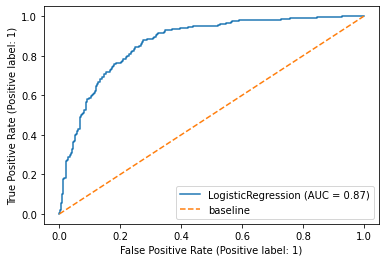

In [69]:
plot_roc_curve(logreg, X_test_sc, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label = 'baseline', linestyle='--')

# add a legend
plt.legend();